In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.autonotebook import tqdm


/home/ed/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  after removing the cwd from sys.path.


In [4]:
%matplotlib notebook
np.set_printoptions(precision=4, linewidth=500, threshold=500, suppress=True)

In [5]:
import sys
sys.path.append('..')

In [295]:
from model.laplacian import Laplacian
from model.features import Features
from model.targets import Targets
from model.regression.basic import LinearRegression, LassoRegression, RidgeRegression, NaiveRegression
from model.regression.glskgr import GLSKGR, GraphFeaturesGLSKGR
from model.regression.kgr import KGR, GraphFeaturesKGR

from model.utils import diag_i, make_ST

In [7]:
laplacian = Laplacian()

In [240]:
features = Features(transform='quantile')

In [29]:
metrics = ['Ozone', 'SO2', 'CO', 'NO2', 'PM25', 'PM10']

targets = {metric: Targets(metric, transform='log') for metric in metrics}

In [31]:
model_kgr = KGR(gamma= 0.0037, K_std=20, filter_func='sigmoid', beta=62).set_laplacian(laplacian).set_data(features, targets['Ozone'])

In [34]:
model_kgr.optimize()

({'gamma': 0.05179474679231213,
  'K_std': 12.648552168552959,
  'filter_func': 'sigmoid',
  'beta': 5.963623316594643},
 0.6111765405919927)

In [241]:
model = GraphFeaturesKGR(gamma= 0.0037, beta_f=5, filter_func='exponential', beta=62).set_laplacian(laplacian).set_data(features, targets['Ozone'])

In [245]:
model.optimize()

({'gamma': 0.0019306977288832496,
  'K_std': 20,
  'filter_func': 'exponential',
  'beta': 8.685113737513525,
  'beta_f': 2.8117686979742302},
 0.6629787707589792)

In [268]:
model_glsgf = GraphFeaturesGLSKGR(**{'gamma': 0.0019306977288832496,
  'filter_func': 'exponential',
  'beta': 8.685113737513525,
  'beta_f': 2.8117686979742302}).set_laplacian(laplacian).set_data(features, targets['Ozone'])

In [269]:
model_glsgf.solve_GLS()

In [270]:
model_glsgf.RMSE_unlabelled_full()

0.7813106061337386

In [273]:
model_glsgf.set_Fvar()

In [276]:
np.real(model_glsgf.Fvar) ** 0.5

array([[0.0903, 0.1621, 0.1301, ..., 0.4351, 0.4205, 0.3548],
       [0.0908, 0.1676, 0.1332, ..., 0.459 , 0.4437, 0.3742],
       [0.3858, 0.4954, 0.457 , ..., 0.6833, 0.6514, 0.5635],
       ...,
       [0.093 , 0.1563, 0.1314, ..., 0.3213, 0.3083, 0.2624],
       [0.0969, 0.1619, 0.1366, ..., 0.3292, 0.3157, 0.2689],
       [0.0943, 0.1683, 0.1383, ..., 0.3683, 0.3542, 0.3009]])

In [278]:
model_glsgf.params['gamma']

0.0019306977288832496

In [300]:
np.outer(diag_i(model_glsgf.SN), diag_i(make_ST(model_glsgf.targets.T_, model_glsgf.theta)))

array([[0.3705, 0.3705, 0.3705, ..., 0.3705, 0.3705, 0.3705],
       [0.4829, 0.4829, 0.4829, ..., 0.4829, 0.4829, 0.4829],
       [0.4502, 0.4502, 0.4502, ..., 0.4502, 0.4502, 0.4502],
       ...,
       [0.2332, 0.2332, 0.2332, ..., 0.2332, 0.2332, 0.2332],
       [0.4356, 0.4356, 0.4356, ..., 0.4356, 0.4356, 0.4356],
       [0.28  , 0.28  , 0.28  , ..., 0.28  , 0.28  , 0.28  ]])

array([1., 1., 1., ..., 1., 1., 1.])

In [285]:
A = np.random.normal(size=(10, 10))

In [306]:
G = np.array([[0.6444, 0.8207, 0.6912, 0.7512, 0.6728],
 [0.6539, 0.8438, 0.7201, 0.7809, 0.6899]])

G

array([[0.6444, 0.8207, 0.6912, 0.7512, 0.6728],
       [0.6539, 0.8438, 0.7201, 0.7809, 0.6899]])

In [307]:
G + np.abs(np.random.normal(loc=0, scale=0.03, size=G.shape))

array([[0.6835, 0.8602, 0.7392, 0.7859, 0.7008],
       [0.6706, 0.8685, 0.7703, 0.8003, 0.6957]])

In [309]:
model_kgr.Fvar.shape

(1382, 1570)

In [310]:
model_kgr.targets.T

1570

<IPython.core.display.Javascript object>


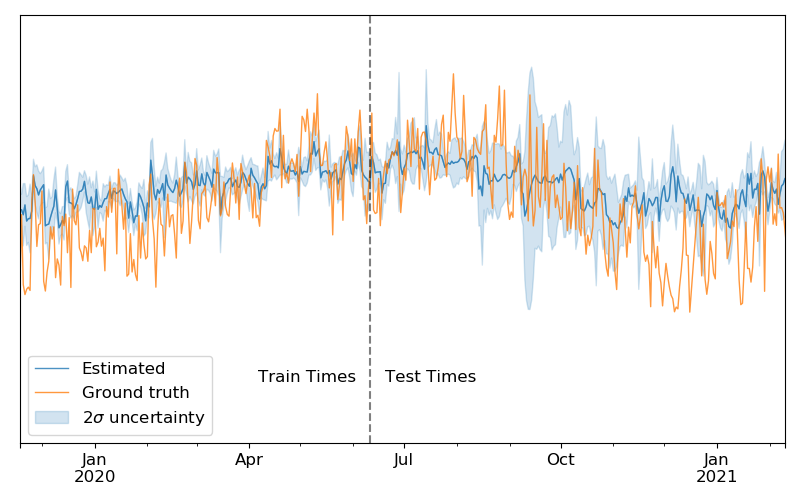

/home/ed/miniconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:5293: ComplexWarning: Casting complex values to real discards the imaginary part
  X[0] = start
/home/ed/miniconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:5294: ComplexWarning: Casting complex values to real discards the imaginary part
  X[N + 1] = end
/home/ed/miniconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:5299: ComplexWarning: Casting complex values to real discards the imaginary part
  X[N + 2:, 1] = y2slice[::-1]
/home/ed/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [277]:
fig, ax = plt.subplots(figsize=(8, 5))

site = '16_1_10'

x = model_kgr.F.columns

y_pred = model_glsgf.F.loc[site]
y_obs = model_glsgf.targets.Y0.loc[site]
y_unc = model_glsgf.Fvar.loc[site] ** 0.5


y_pred.plot(lw=1, label='Estimated',  ax=ax, alpha=0.8)

y_obs.plot(lw=1, label='Ground truth',  ax=ax, alpha=0.8)

ax.fill_between(x, y_pred, y_pred + 2 * y_unc, alpha=0.2, color='tab:blue', label='2$\sigma$ uncertainty', zorder=-1)
ax.fill_between(x, y_pred, y_pred - 2 * y_unc, alpha=0.2, color='tab:blue', zorder=-1)


ax.set_yticks([])



ax.legend(loc='lower left', fontsize='large')


ax.set_xlim(x[1050], x[1500])
ax.set_ylim(-4.5, 2.5)

ax.axvline(x[1256], color='k', alpha=0.5, ls='--')

ax.text(x[1265], -3.5,  'Test Times', fontsize='large')
ax.text(x[1190], -3.5,  'Train Times', fontsize='large')


for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize('large')
    
plt.tight_layout()


# plt.savefig('prediction-time-series.pdf')

In [197]:
x

DatetimeIndex(['2017-01-02', '2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06', '2017-01-07', '2017-01-08', '2017-01-09', '2017-01-10', '2017-01-11',
               ...
               '2021-04-11', '2021-04-12', '2021-04-13', '2021-04-14', '2021-04-15', '2021-04-16', '2021-04-17', '2021-04-18', '2021-04-19', '2021-04-20'],
              dtype='datetime64[ns]', length=1570, freq=None)

In [180]:
leg.get_lines()

In [173]:
dir(leg

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_agg_filter',
 '_alpha',
 '_animated',
 '_approx_text_height',
 '_auto_legend_data',
 '_axes',
 '_bbox_to_anchor',
 '_clipon',
 '_clippath',
 '_contains',
 '_custom_handler_map',
 '_default_handler_map',
 '_draggable',
 '_drawFrame',
 '_find_best_position',
 '_findoffset',
 '_fontsize',
 '_get_anchored_bbox',
 '_get_clipping_extent_bbox',
 '_get_loc',
 '_gid',
 '_in_layout',
 '_init_legend_box',
 '_label',
 '_legend_box',
 '_legend_handle_box',
 '_legend_title_box',
 '_loc',
 '_loc_real',
 '_loc_used_default',
 '_mode',
 '_mouseover',
 '_ncol',
 '_oid',
 '_path_effects',
 '_picker',
 '_prop_order',
 '_pr

In [ ]:
axes[0].legend

In [ ]:
axes[1].text

In [36]:
model_kgr = KGR(**{'gamma': 0.05179474679231213,
  'K_std': 12.648552168552959,
  'filter_func': 'sigmoid',
  'beta': 5.963623316594643}).set_laplacian(laplacian).set_data(features, targets['Ozone'])

<IPython.core.display.Javascript object>


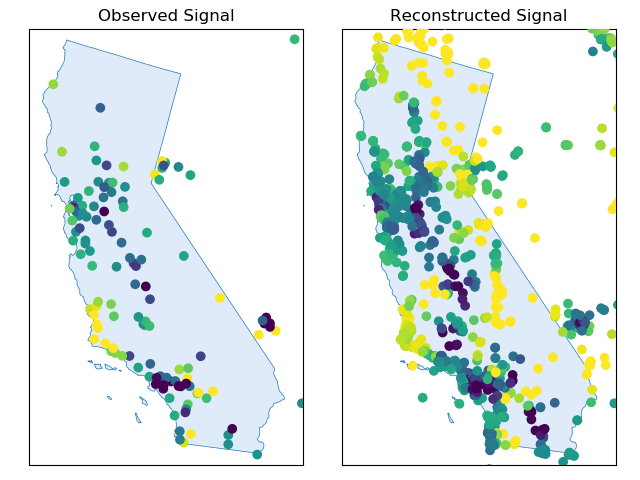

In [261]:
fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True)

ti = 6
t = model_kgr.targets.Y.columns[ti]

laplacian.distance.cali.plot_outline(axes[1], dict(color='tab:blue'), fill={'fc': '#e0ebf9', 'lw': 0.5, 'ec': 'tab:blue'})
laplacian.distance.cali.plot_outline(axes[0], dict(color='tab:blue'), fill={'fc': '#e0ebf9', 'lw': 0.5, 'ec': 'tab:blue'})

vmin = np.quantile(model_kgr.targets.Y.loc[:, t], 0.1)
vmax = np.quantile(model_kgr.targets.Y.loc[:, t], 0.9)

axes[1].scatter(model_kgr.targets.sites['x'], model_kgr.targets.sites['y'], c=model_kgr.F.loc[:, t], alpha=1, vmin=vmin, vmax=vmax, zorder=np.inf)

axes[0].scatter(model_kgr.targets.sites.loc[model_kgr.targets.train_sites, 'x'], model_kgr.targets.sites.loc[model_kgr.targets.train_sites, 'y'], c=model_kgr.targets.Y.loc[:, t], alpha=1, vmin=vmin, vmax=vmax, zorder=np.inf)

axes[0].set_title('Observed Signal')
axes[1].set_title('Reconstructed Signal')

plt.tight_layout()

plt.savefig('reconstructed.pdf')




In [23]:
def get_results():
    
    models = {'KGR': KGR, 
              'LinearRegression': LinearRegression, 
              'RidgeRegression': RidgeRegression, 
              'LassoRegression': LassoRegression, 
              'GLSKGR': GLSKGR}

    init_params = {'KGR': dict(gamma=0.01, K_std=50, filter_func='sigmoid', beta=50), 
                   'LinearRegression': dict(fit_intercept=True), 
                   'RidgeRegression': dict(fit_intercept=True, alpha=50),
                   'LassoRegression': dict(fit_intercept=True, alpha=1)}


    model_names = ['KGR', 'LinearRegression', 'RidgeRegression', 'LassoRegression', 'GLSKGR']

    opt_params = {metric: {model: {} for model in model_names} for metric in metrics}

    RMSE = {'Missing Nodes':  {model: {} for model in model_names}, 
            'Labelled':       {model: {} for model in model_names}, 
            'Missing Dates':  {model: {} for model in model_names}, 
            'All Unlabelled': {model: {} for model in model_names}}

    
    metrics_bar = tqdm(metrics)

    for metric in metrics_bar:

        metrics_bar.set_description(metric)

        models_bar = tqdm(models, leave=False)

        for model in models_bar:

            models_bar.set_description(model)

            if model != 'GLSKGR':
                reg = models[model](**init_params[model])

                if model != 'KGR':
                    opt_params[metric][model] = reg.set_data(features, targets[metric]).optimize()[0]

                else:
                    opt_params[metric][model] = reg.set_laplacian(laplacian).set_data(features, targets[metric]).optimize()[0]

            else:
                reg = models['GLSKGR'](**opt_params[metric]['KGR']).set_laplacian(laplacian).set_data(features, targets[metric])
                opt_params[metric]['GLSKGR'] = opt_params[metric]['KGR']
                reg.solve_GLS()

            RMSE['Missing Nodes'][model][metric] = reg.RMSE_missing_nodes()
            RMSE['Labelled'][model][metric] = reg.RMSE_labelled()
            RMSE['Missing Dates'][model][metric] = reg.RMSE_missing_times()
            RMSE['All Unlabelled'][model][metric] = reg.RMSE_unlabelled_full()
            
    return opt_params, RMSE
            

In [24]:
opt_params, RMSE = get_results()

In [25]:
pd.DataFrame(RMSE['All Unlabelled']).T.drop('SO2', axis=1)#.to_csv('results/unlabelled_full.csv')

,Ozone,CO,NO2,PM25,PM10
KGR,0.615449,0.735879,0.599236,0.749145,0.633629
LinearRegression,0.723574,0.768096,0.773384,0.816315,0.777558
RidgeRegression,0.704979,0.744427,0.780301,0.783974,0.731608
LassoRegression,0.679058,0.724803,0.739269,0.759241,0.701147
GLSKGR,0.662691,0.745393,0.665544,0.785514,0.665610


In [27]:
pd.DataFrame(RMSE['Missing Nodes']).T.drop('SO2', axis=1)#.to_csv('results/missing_nodes.csv')

,Ozone,CO,NO2,PM25,PM10
KGR,0.608420,0.883679,0.638532,0.692877,0.592155
LinearRegression,0.764155,0.864438,0.924089,0.818205,0.773625
RidgeRegression,0.764472,0.864822,0.925000,0.819010,0.774243
LassoRegression,0.767042,0.867911,0.928360,0.820848,0.775833
GLSKGR,0.678349,0.904138,0.686995,0.722991,0.655298


In [26]:
pd.DataFrame(RMSE['Missing Dates']).T.drop('SO2', axis=1)#.to_csv('results/unlabelled_dates.csv')

,Ozone,CO,NO2,PM25,PM10
KGR,0.592735,0.539675,0.552580,0.770604,0.654792
LinearRegression,0.652398,0.662703,0.521524,0.798053,0.773413
RidgeRegression,0.607211,0.604531,0.551308,0.728811,0.665495
LassoRegression,0.537975,0.541524,0.402299,0.661069,0.585522
GLSKGR,0.626720,0.539121,0.643153,0.815208,0.667832


In [28]:
pd.DataFrame(RMSE['Labelled']).T.drop('SO2', axis=1)#.to_csv('results/labelled.csv')

,Ozone,CO,NO2,PM25,PM10
KGR,0.317762,0.202276,0.544492,0.534491,0.493960
LinearRegression,0.439377,0.374526,0.344250,0.474253,0.497572
RidgeRegression,0.443431,0.380649,0.350041,0.478920,0.503214
LassoRegression,0.466472,0.410098,0.372237,0.497190,0.524526
GLSKGR,0.310504,0.051383,0.625151,0.546650,0.450996


In [33]:
opt_params['Ozone']

{'KGR': {'gamma': 0.07196856730011514,
  'K_std': 10.985411419875584,
  'filter_func': 'sigmoid',
  'beta': 5.963623316594643},
 'LinearRegression': {'fit_intercept': True},
 'RidgeRegression': {'fit_intercept': True, 'alpha': 686.6488450042998},
 'LassoRegression': {'fit_intercept': True, 'alpha': 0.01151395399326447},
 'GLSKGR': {'gamma': 0.07196856730011514,
  'K_std': 10.985411419875584,
  'filter_func': 'sigmoid',
  'beta': 5.963623316594643}}